# Testing script for PAMIP EOFs

## NOTE: vertically-averaged is not correct.

- See: this [notebook](/home/links/ct715/eddy_feedback/chapter1/annular_modes/pamip_eof1s.py)

In [24]:
import xarray as xr
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from eofs.xarray import Eof
import seaborn as sns
import scipy as sp

import functions.data_wrangling as dw
import functions.eddy_feedback as ef

In [25]:
def eof_calc_alt(data,lats):

    coslat = np.cos(np.deg2rad(lats.values)).clip(0., 1.)
    wgts = np.sqrt(coslat)[np.newaxis, np.newaxis, :]

    solver = Eof(data, weights=wgts, center=True)

    eofs = solver.eofsAsCovariance(neofs=1)
    pc1 = solver.pcs(npcs=1, pcscaling=1)

    variance_fractions = solver.varianceFraction(neigs=3)

    return eofs, pc1, variance_fractions, solver

# Import data

In [26]:
# obtain model names from directory
dir = '/home/links/ct715/data_storage/PAMIP/processed_monthly/combined_ua_epfy_divFy/1.1_pdSST-pdSIC'
path_dir = Path(dir)
models_dir = sorted(path_dir.iterdir())
models = [model.name.split('_')[0] for model in models_dir]

# import models into dictionary
ds = {}
for model in models:
    # import data
    ds[model] = xr.open_dataset(f'{dir}/{model}_1.1_u_ubar_epfy_divFy.nc')
    # add model name to dataset
    ds[model].attrs['model'] = model

In [27]:
cesm2 = ds[models[1]]
cesm2

<xarray.Dataset> Size: 9GB
Dimensions:  (lat: 128, lon: 256, level: 19, time: 12, ens_ax: 300)
Coordinates:
  * lat      (lat) float64 1kB -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 2kB 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * level    (level) float32 76B 1e+03 925.0 850.0 700.0 ... 20.0 10.0 5.0 1.0
  * time     (time) datetime64[ns] 96B 2000-06-16 ... 2001-05-16T12:00:00
Dimensions without coordinates: ens_ax
Data variables:
    u        (ens_ax, time, level, lat, lon) float32 9GB ...
    epfy     (ens_ax, time, level, lat) float64 70MB ...
    divFy    (ens_ax, time, level, lat) float64 70MB ...
    ubar     (ens_ax, time, level, lat) float32 35MB ...
Attributes:
    model:    CNRM-CM6-1

### Take seasonal average then calculate ensemble anomalies...

- The leading EOF is similar to my incorrect calculation with JRA55

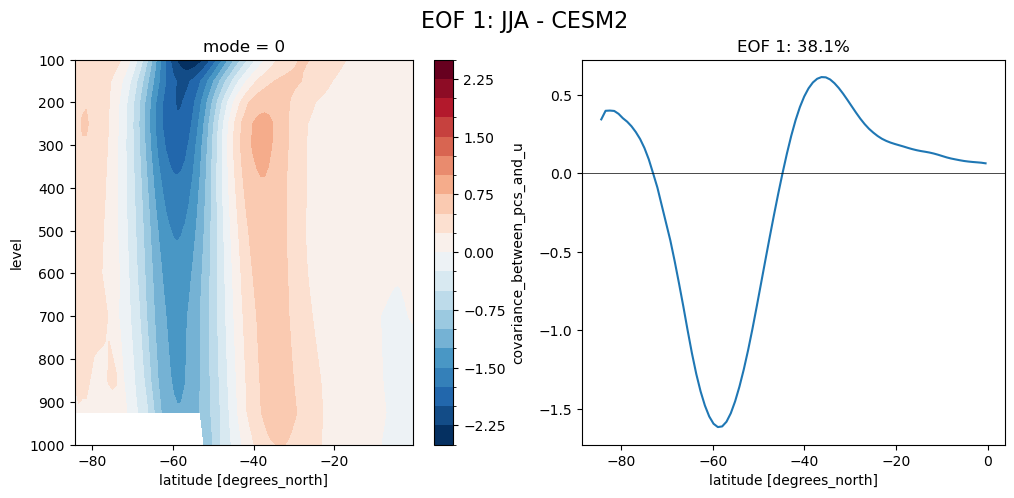

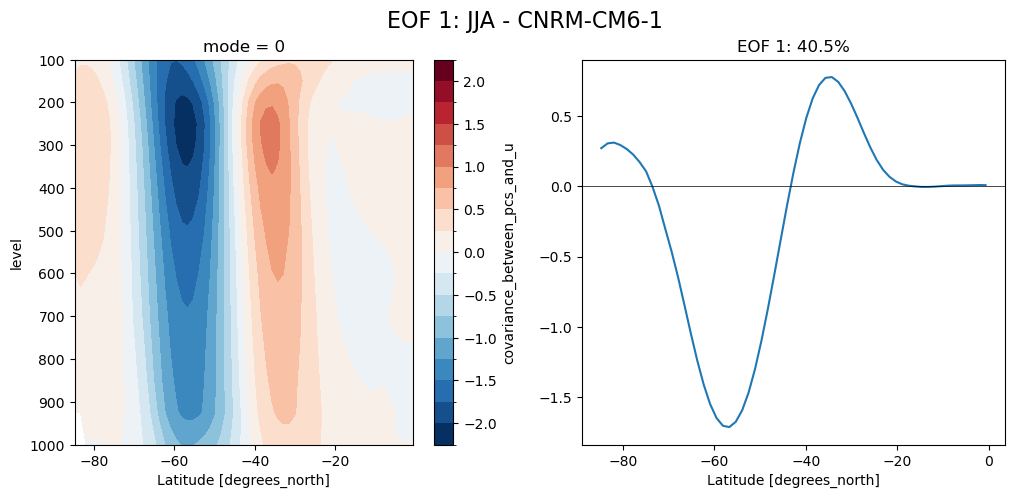

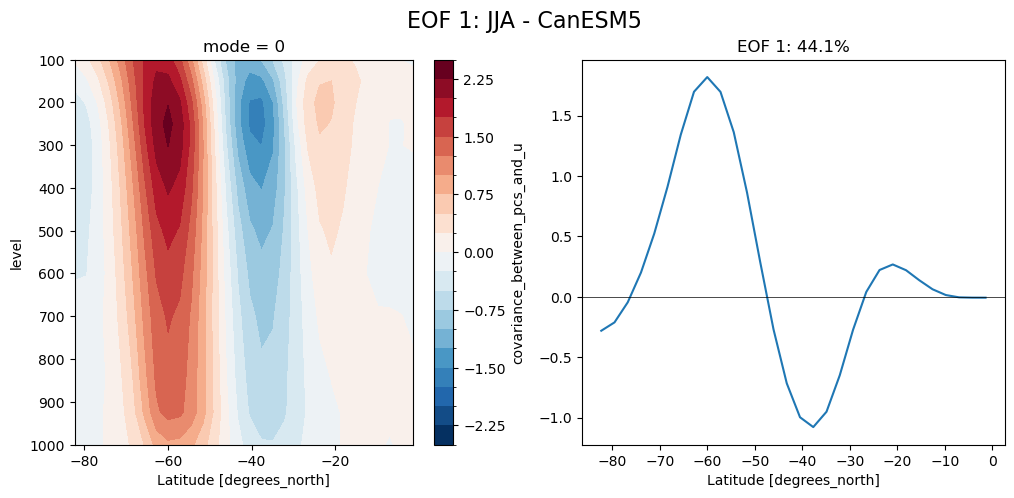

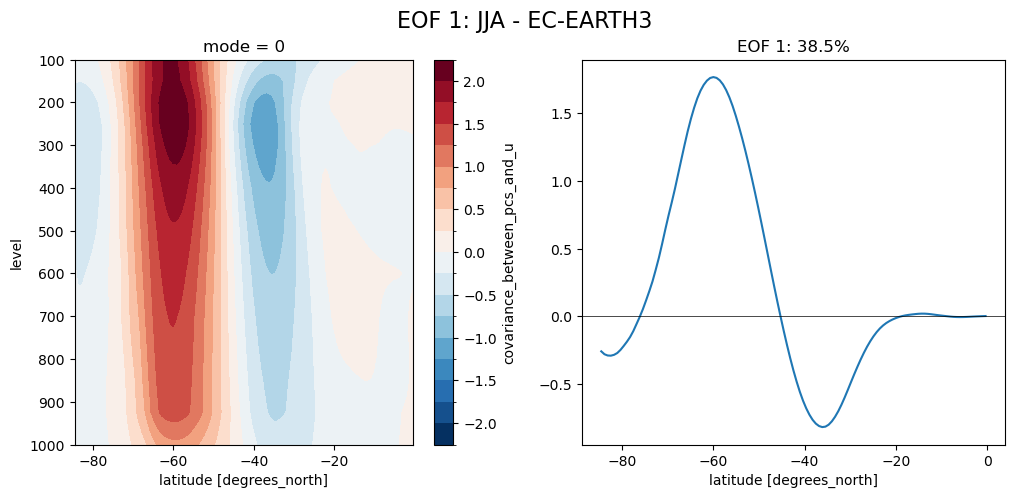

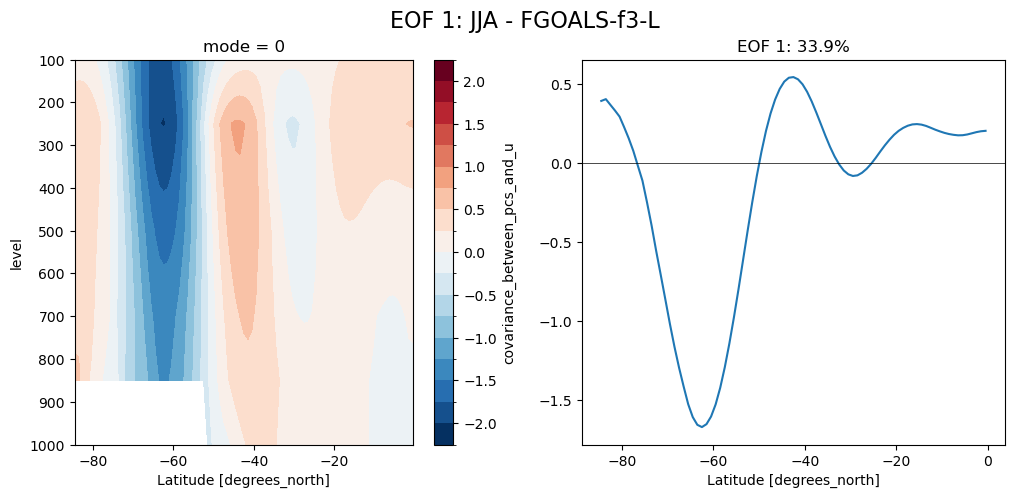

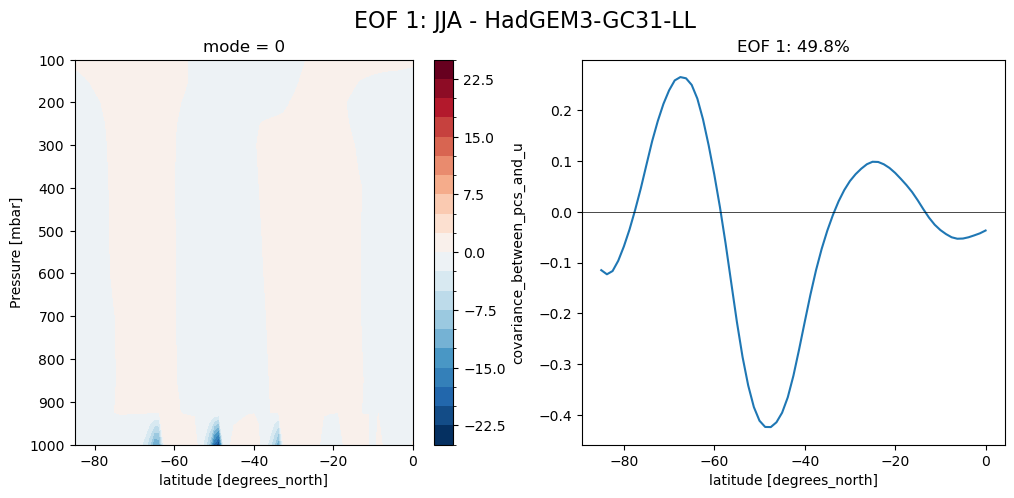

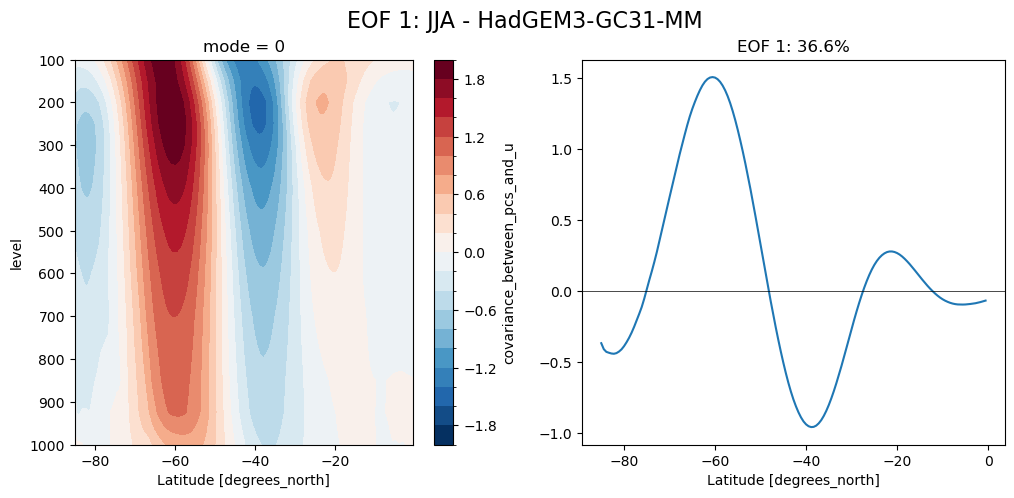

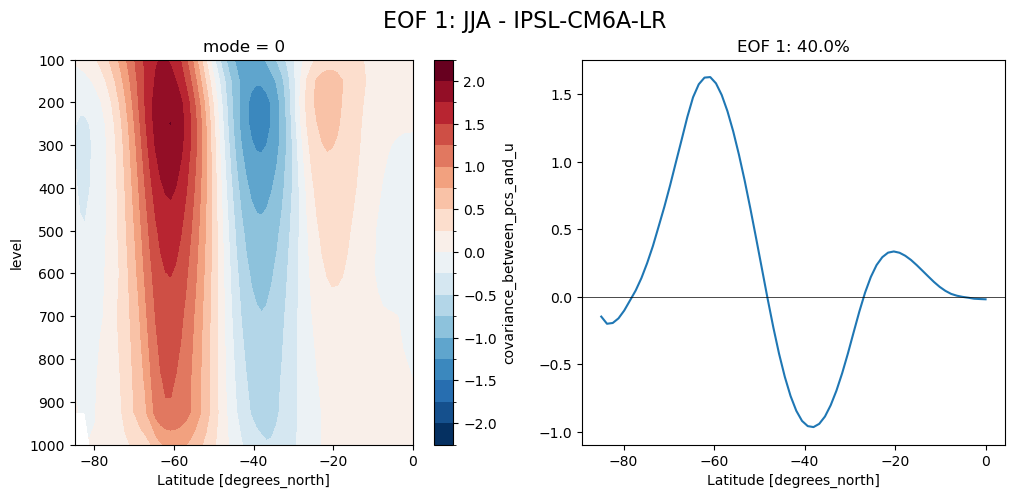

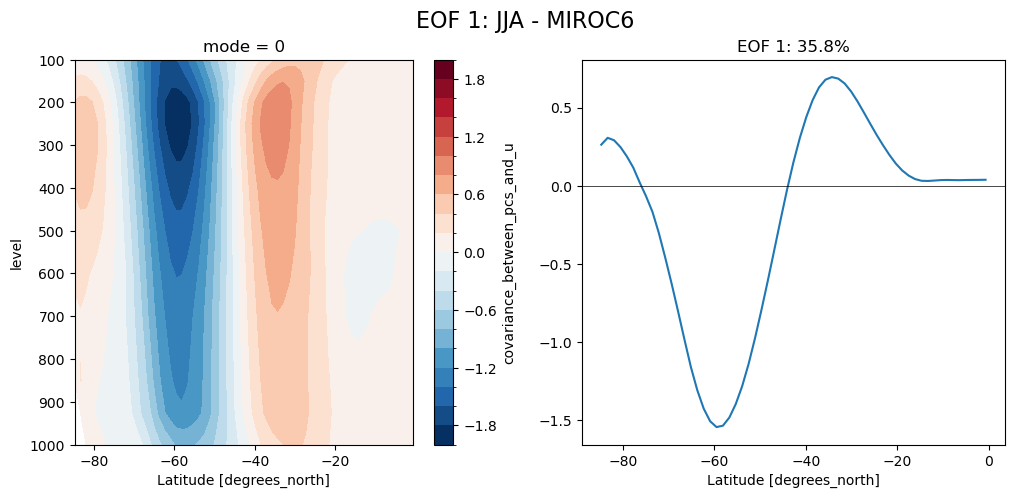

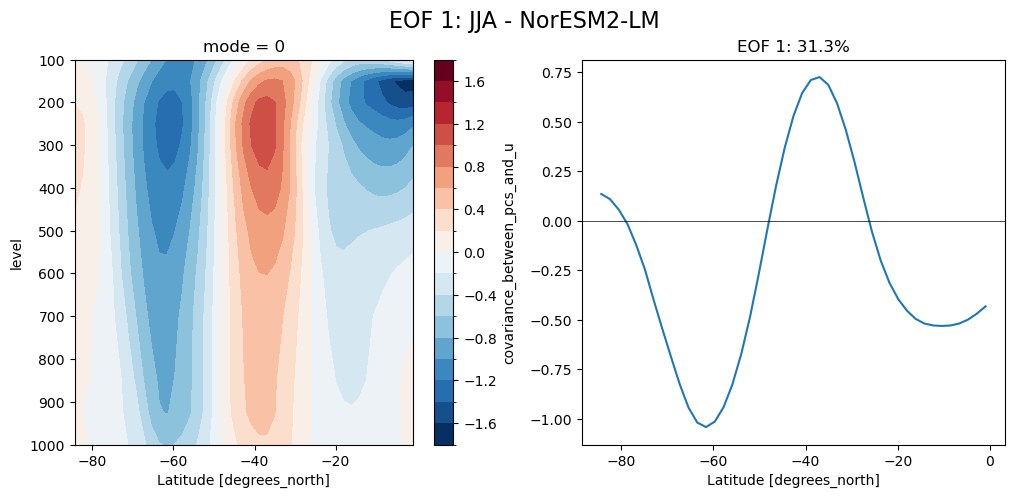

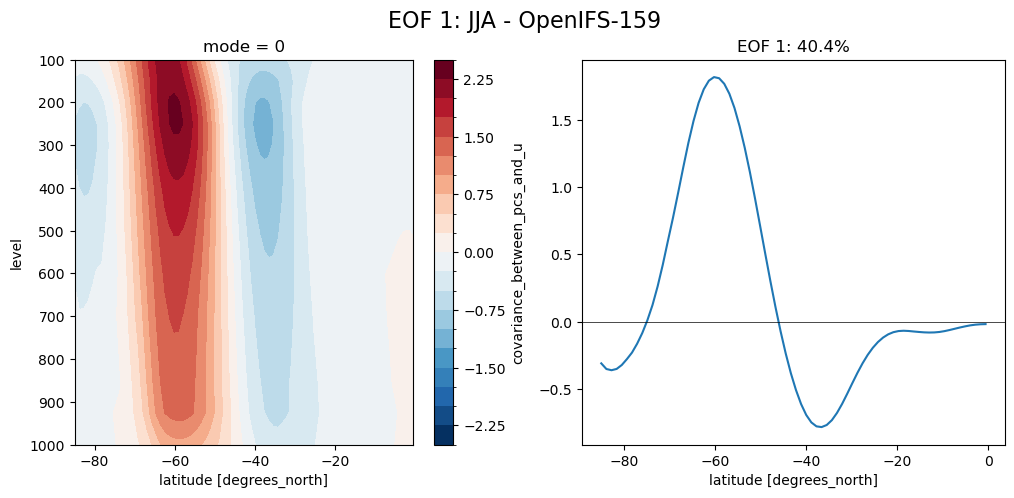

In [ ]:
for model in models:
    
    dataset = ds[model]

    # select JJA months
    jja = dataset.sel(time=dataset.time.dt.month.isin([7, 8, 9])).mean(dim='time')

    # Compute ensemble anomalies instead of temporal anomalies
    u_ens = jja['u']  # shape: (ensemble, level, lat, lon)
    var_anoms = u_ens - u_ens.mean(dim='ens_ax')
    var_anoms = var_anoms.mean('lon').sel(lat=slice(-85,0), level=slice(1000, 100))
    var_anoms = var_anoms.rename({'ens_ax': 'time'})  # if needed by eof_calc_alt

    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms, var_anoms.lat)

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    eofs.sel(mode=0).plot.contourf(yincrease=False, levels=21, ax=ax1)

    dp = eofs.level.diff('level')
    wgt_avg = (eofs * dp).sum('level') / dp.sum('level')

    wgt_avg.sel(mode=0).plot.line(ax=ax2)
    ax2.axhline(0, color='k', lw=0.5)
    ax2.set_title(f"EOF 1: {variance_fractions[0].values*100:.1f}%")
    fig.suptitle(f'EOF 1: JJA - {model}', fontsize=16)
    plt.show()

### Take seasonal average after calculating anomalies

- Doesn't appear to make a difference.

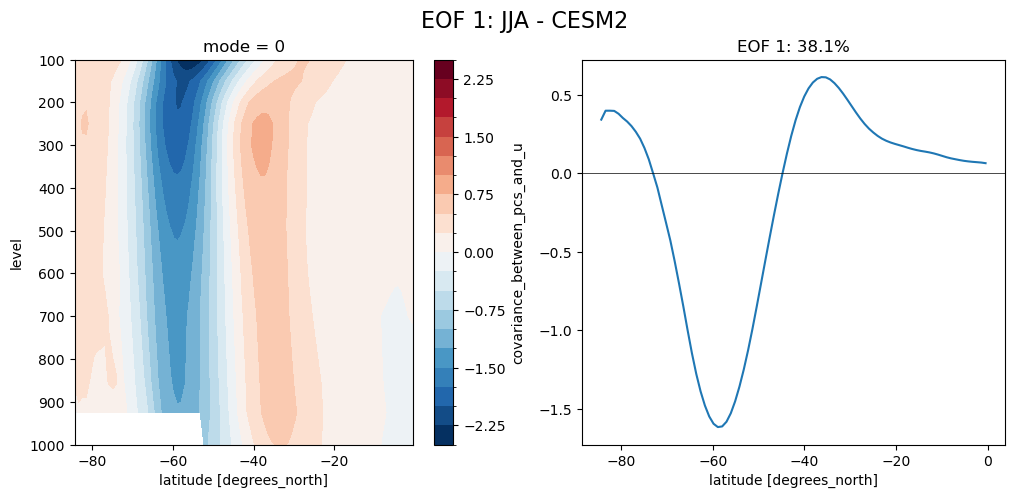

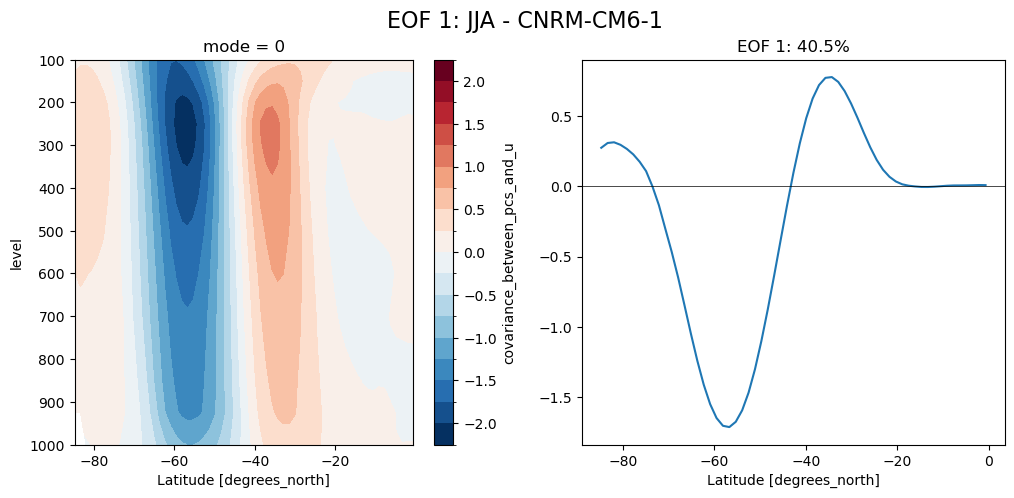

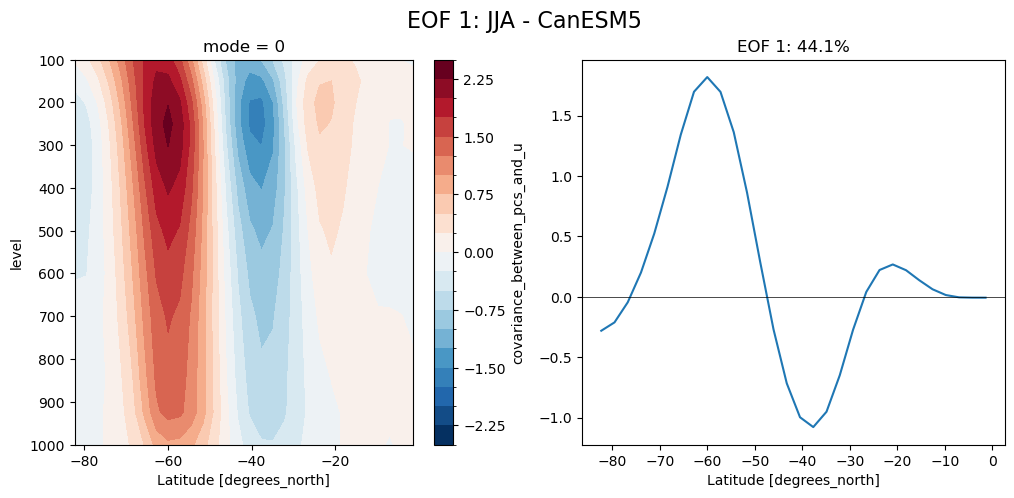

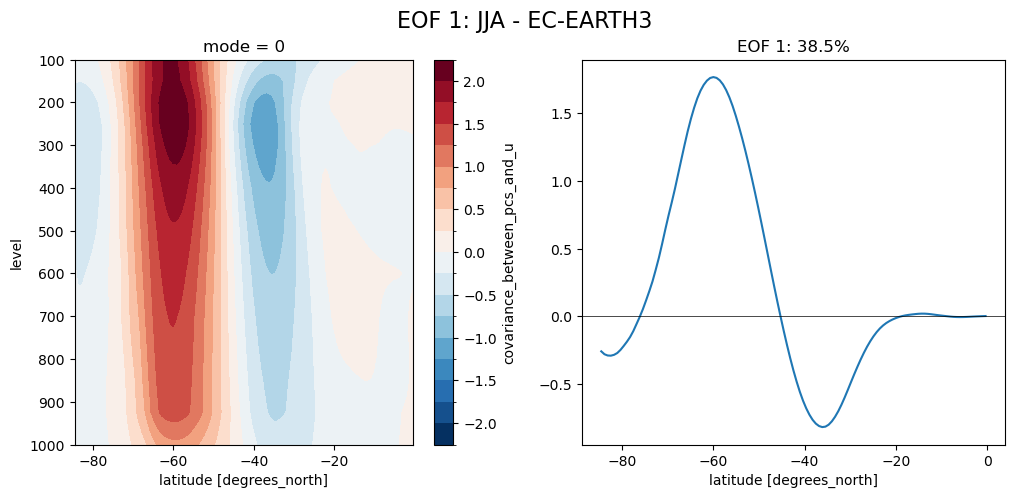

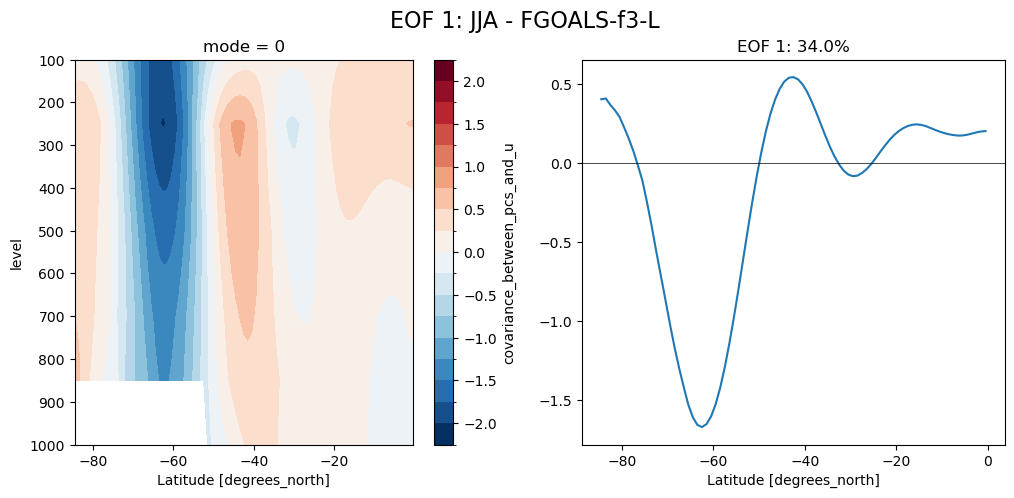

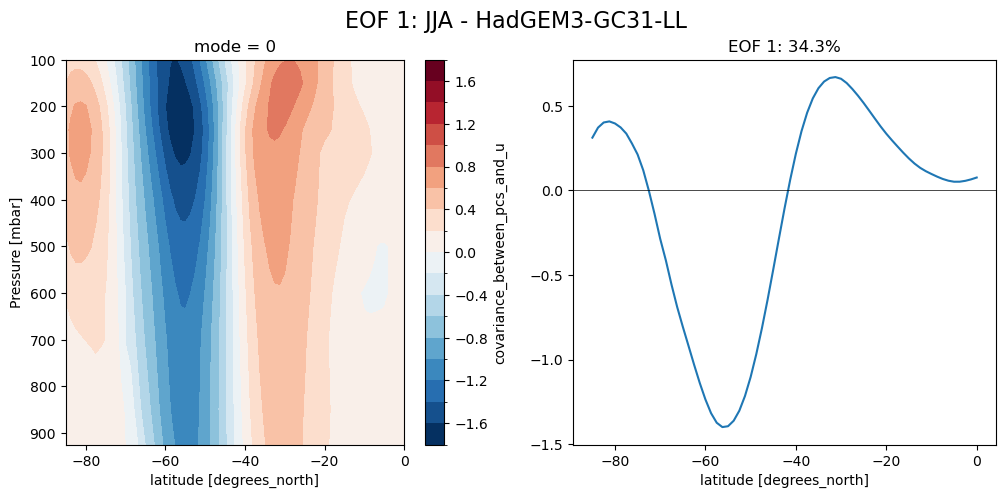

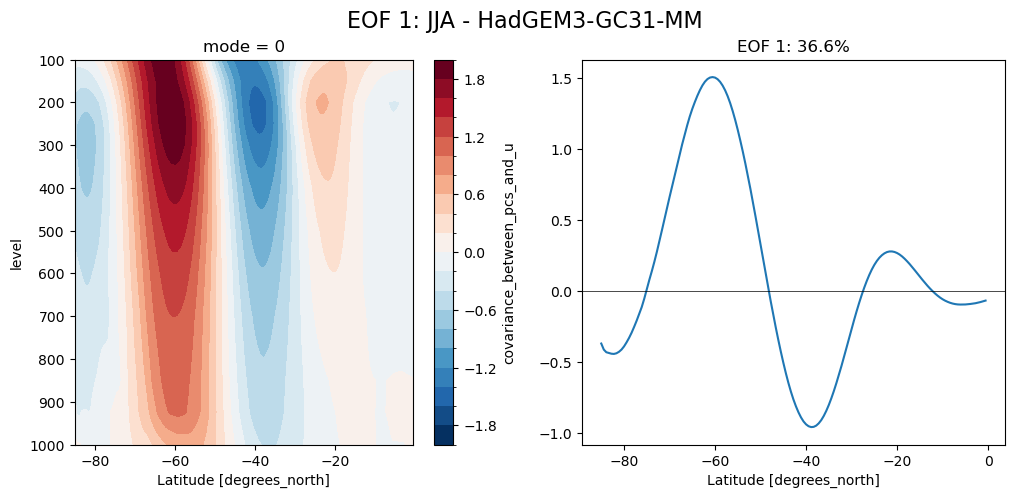

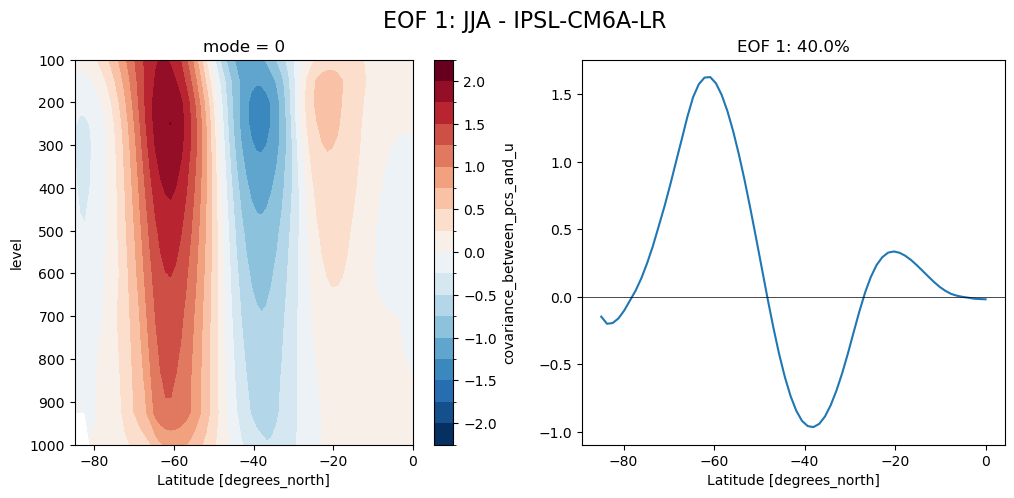

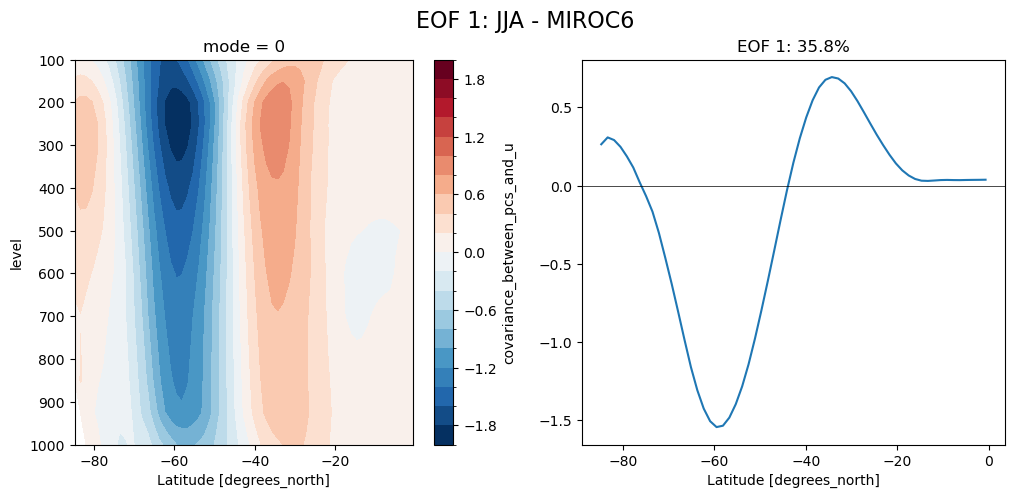

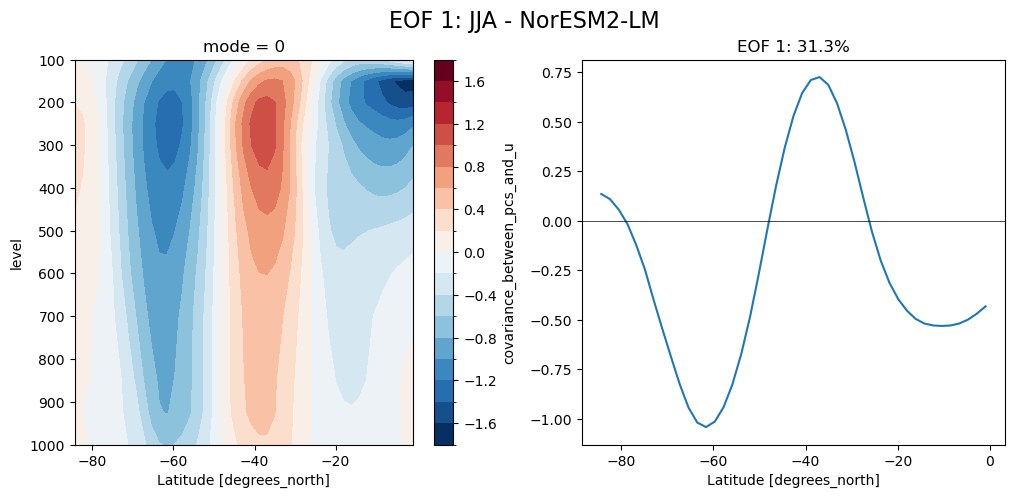

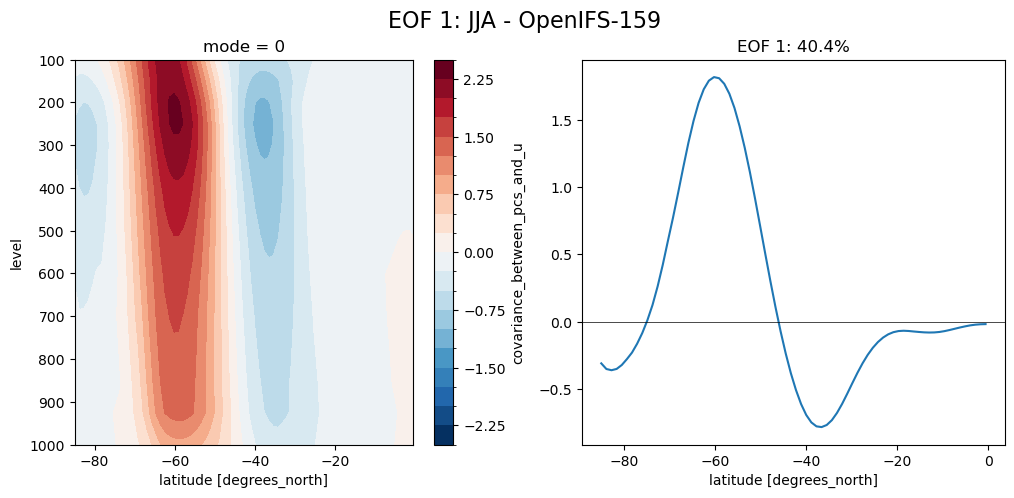

In [31]:
for model in models:
    
    dataset = ds[model]
    
    if model == 'HadGEM3-GC31-LL':
        dataset = dataset.where(dataset.level < 1000., drop=True)

    # Compute ensemble anomalies instead of temporal anomalies
    u_ens = dataset['u']  # shape: (ensemble, level, lat, lon)
    var_anoms = u_ens - u_ens.mean(dim='ens_ax')
    var_anoms = var_anoms.mean('lon').sel(lat=slice(-85,0), level=slice(1000, 100))
    var_anoms = var_anoms.sel(time=var_anoms.time.dt.month.isin([7, 8, 9])).mean(dim='time')

    var_anoms = var_anoms.rename({'ens_ax': 'time'})  # if needed by eof_calc_alt
    eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms, var_anoms.lat)

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    eofs.sel(mode=0).plot.contourf(yincrease=False, levels=21, ax=ax1)

    dp = eofs.level.diff('level')
    wgt_avg = (eofs * dp).sum('level') / dp.sum('level')

    wgt_avg.sel(mode=0).plot.line(ax=ax2)
    ax2.axhline(0, color='k', lw=0.5)
    ax2.set_title(f"EOF 1: {variance_fractions[0].values*100:.1f}%")
    fig.suptitle(f'EOF 1: JJA - {model}', fontsize=16)
    plt.show()